In [1]:
! pip install gym-retro==0.8.0 stable-baselines3[extra]==1.3.0 botorch==0.6.3.1
!pip install torchviz torch-summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.0/162.0 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 713.2/713.2 KB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.6/310.6 KB 16.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=53e150878d4939d60bff98e20a83954ccdb4ac4b31df151042d5fa109fa3c845
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
  

In [2]:

! git clone https://github.com/thunderock/BiasNet.git
! python -m retro.import BiasNet/roms/
! cp BiasNet/roms/StreetFighterIISpecialChampionEdition-Genesis/* /opt/conda/lib/python3.7/site-packages/retro/data/stable/StreetFighterIISpecialChampionEdition-Genesis/

! cp -r BiasNet/* .
! rm -rf BiasNet
! mkdir models
! ls

Cloning into 'BiasNet'...
remote: Enumerating objects: 1049, done.
remote: Counting objects: 100% (231/231), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 1049 (delta 112), reused 231 (delta 112), pack-reused 818
Receiving objects: 100% (1049/1049), 302.03 MiB | 38.13 MiB/s, done.
Resolving deltas: 100% (407/407), done.
Updating files: 100% (300/300), done.
Importing StreetFighterIISpecialChampionEdition-Genesis
Imported 1 games
mkdir: cannot create directory ‘models’: File exists
LICENSE		    constants.py	   layers.py	     roms
README.md	    driver.py		   main.py	     trainer.py
__notebook__.ipynb  environment.py	   models	     tuner.py
actor_critic.py     experiments		   report	     utils.py
callbacks.py	    feature_extractors.py  requirements.txt


In [3]:
from torchviz import make_dot, make_dot_from_trace
from constants import *
from utils import plot_study, GameState, record_model_playing
from environment import StreetFighterEnv
from trainer import _get_model
from callbacks import get_eval_callback
from stable_baselines3 import PPO, A2C
from actor_critic import A2CCNNPolicy
from feature_extractors import CNNExtractorWithAttention, CNNExtractor
from tuner import Tuner
import os
from layers import ActorCriticLayer

# MODEL WITH ATTENTION

In [4]:
model_params = {'gamma': 0.8074138106735396, 'learning_rate': 0.0001, 'gae_lambda': 0.8787060424267222}
model = A2C
feature_extractor_class = CNNExtractorWithAttention
policy_network = A2CCNNPolicy
policy_kwargs = dict(features_extractor_class=feature_extractor_class,
                     features_extractor_kwargs=dict(features_dim=512, ), actor_critic_class=ActorCriticLayer)
env = StreetFighterEnv(capture_movement=True, state='guile.state', training=True)

model = _get_model(model_type=model, env=env, policy_network=policy_network, feature_extractor_kwargs=policy_kwargs, verbose=1, model_params=model_params)
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


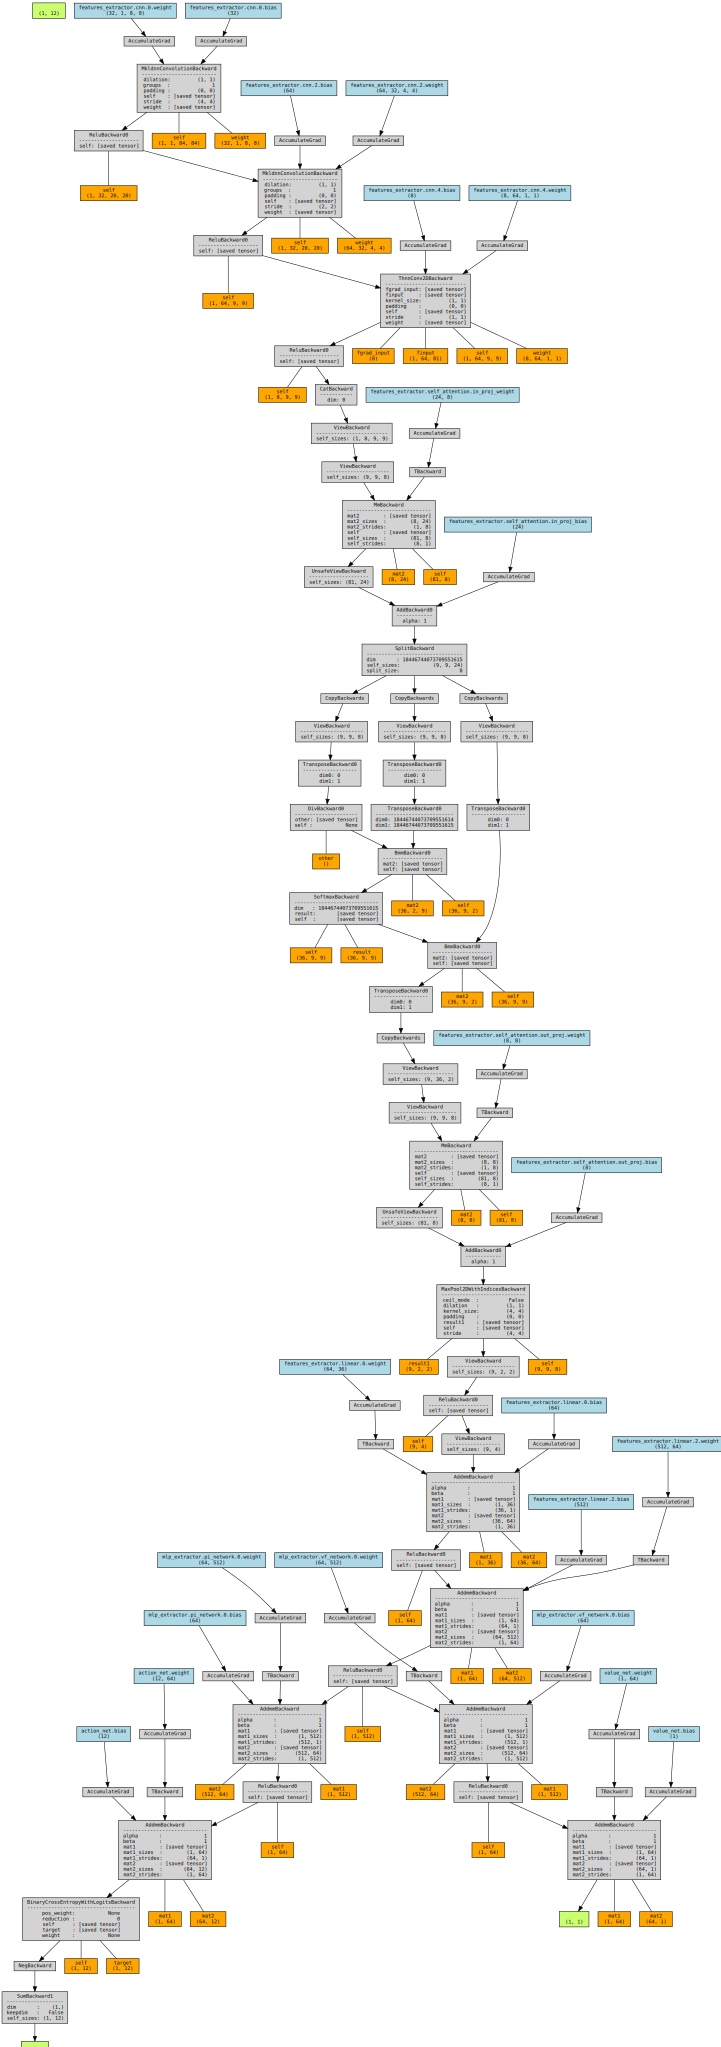

In [5]:
import torch
x = torch.randn(1,1,84,84)
params=dict(model.policy.named_parameters())
make_dot(model.policy(x), params, show_attrs=True, show_saved=True)

In [6]:
from torchsummary import summary
summary(model.policy, (1, 84, 84))

Layer (type:depth-idx)                   Output Shape              Param #
├─CNNExtractorWithAttention: 1-1         [-1, 512]                 --
|    └─Sequential: 2-1                   [-1, 8, 9, 9]             --
|    |    └─Conv2d: 3-1                  [-1, 32, 20, 20]          2,080
|    |    └─ReLU: 3-2                    [-1, 32, 20, 20]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 9, 9]            32,832
|    |    └─ReLU: 3-4                    [-1, 64, 9, 9]            --
|    |    └─Conv2d: 3-5                  [-1, 8, 9, 9]             520
|    |    └─ReLU: 3-6                    [-1, 8, 9, 9]             --
|    └─MultiheadAttention: 2-2           [-1, 9, 8]                --
|    └─Sequential: 2-3                   [-1, 4]                   --
|    |    └─MaxPool2d: 3-7               [-1, 2, 2]                --
|    |    └─Flatten: 3-8                 [-1, 4]                   --
|    |    └─ReLU: 3-9                    [-1, 4]                   --
|    └─

Layer (type:depth-idx)                   Output Shape              Param #
├─CNNExtractorWithAttention: 1-1         [-1, 512]                 --
|    └─Sequential: 2-1                   [-1, 8, 9, 9]             --
|    |    └─Conv2d: 3-1                  [-1, 32, 20, 20]          2,080
|    |    └─ReLU: 3-2                    [-1, 32, 20, 20]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 9, 9]            32,832
|    |    └─ReLU: 3-4                    [-1, 64, 9, 9]            --
|    |    └─Conv2d: 3-5                  [-1, 8, 9, 9]             520
|    |    └─ReLU: 3-6                    [-1, 8, 9, 9]             --
|    └─MultiheadAttention: 2-2           [-1, 9, 8]                --
|    └─Sequential: 2-3                   [-1, 4]                   --
|    |    └─MaxPool2d: 3-7               [-1, 2, 2]                --
|    |    └─Flatten: 3-8                 [-1, 4]                   --
|    |    └─ReLU: 3-9                    [-1, 4]                   --
|    └─

In [7]:
summary(model.policy, (1, 84, 84),  
    branching=False,
    verbose=2,
    col_width=16,
    col_names=["kernel_size","input_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Input Shape      Output Shape     Param #          Mult-Adds
CNNExtractorWithAttention: 1-1           --               [-1, 1, 84, 84]  [-1, 512]        --               --
  cnn.0.weight                           [32, 1, 8, 8]
  cnn.2.weight                           [64, 32, 4, 4]
  cnn.4.weight                           [8, 64, 1, 1]
  self_attention.in_proj_weight          [24, 8]
  self_attention.out_proj.weight         [8, 8]
  linear.0.weight                        [64, 36]
  linear.2.weight                        [512, 64]
Sequential: 2-1                          --               [-1, 1, 84, 84]  [-1, 8, 9, 9]    --               --
  0.weight                               [32, 1, 8, 8]
  2.weight                               [64, 32, 4, 4]
  4.weight                               [8, 64, 1, 1]
Conv2d: 3-1                              [1, 32, 8, 8]    [-1, 1, 84, 84]  [-1, 32, 20, 20] 2,080            819,200
ReLU: 3-2 

Layer (type:depth-idx)                   Kernel Shape     Input Shape      Output Shape     Param #          Mult-Adds
CNNExtractorWithAttention: 1-1           --               [-1, 1, 84, 84]  [-1, 512]        --               --
  cnn.0.weight                           [32, 1, 8, 8]
  cnn.2.weight                           [64, 32, 4, 4]
  cnn.4.weight                           [8, 64, 1, 1]
  self_attention.in_proj_weight          [24, 8]
  self_attention.out_proj.weight         [8, 8]
  linear.0.weight                        [64, 36]
  linear.2.weight                        [512, 64]
Sequential: 2-1                          --               [-1, 1, 84, 84]  [-1, 8, 9, 9]    --               --
  0.weight                               [32, 1, 8, 8]
  2.weight                               [64, 32, 4, 4]
  4.weight                               [8, 64, 1, 1]
Conv2d: 3-1                              [1, 32, 8, 8]    [-1, 1, 84, 84]  [-1, 32, 20, 20] 2,080            819,200
ReLU: 3-2 

# MODEL WITHOUT ATTENTION

In [8]:

model_params = {'gamma': 0.8074138106735396, 'learning_rate': 0.0001, 'gae_lambda': 0.8787060424267222}
model = A2C
feature_extractor_class = CNNExtractor
policy_network = A2CCNNPolicy
policy_kwargs = dict(features_extractor_class=feature_extractor_class,
                     features_extractor_kwargs=dict(features_dim=512, ), actor_critic_class=ActorCriticLayer)
model = _get_model(model_type=model, env=env, policy_network=policy_network, feature_extractor_kwargs=policy_kwargs, verbose=1, model_params=model_params)
env.close()

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


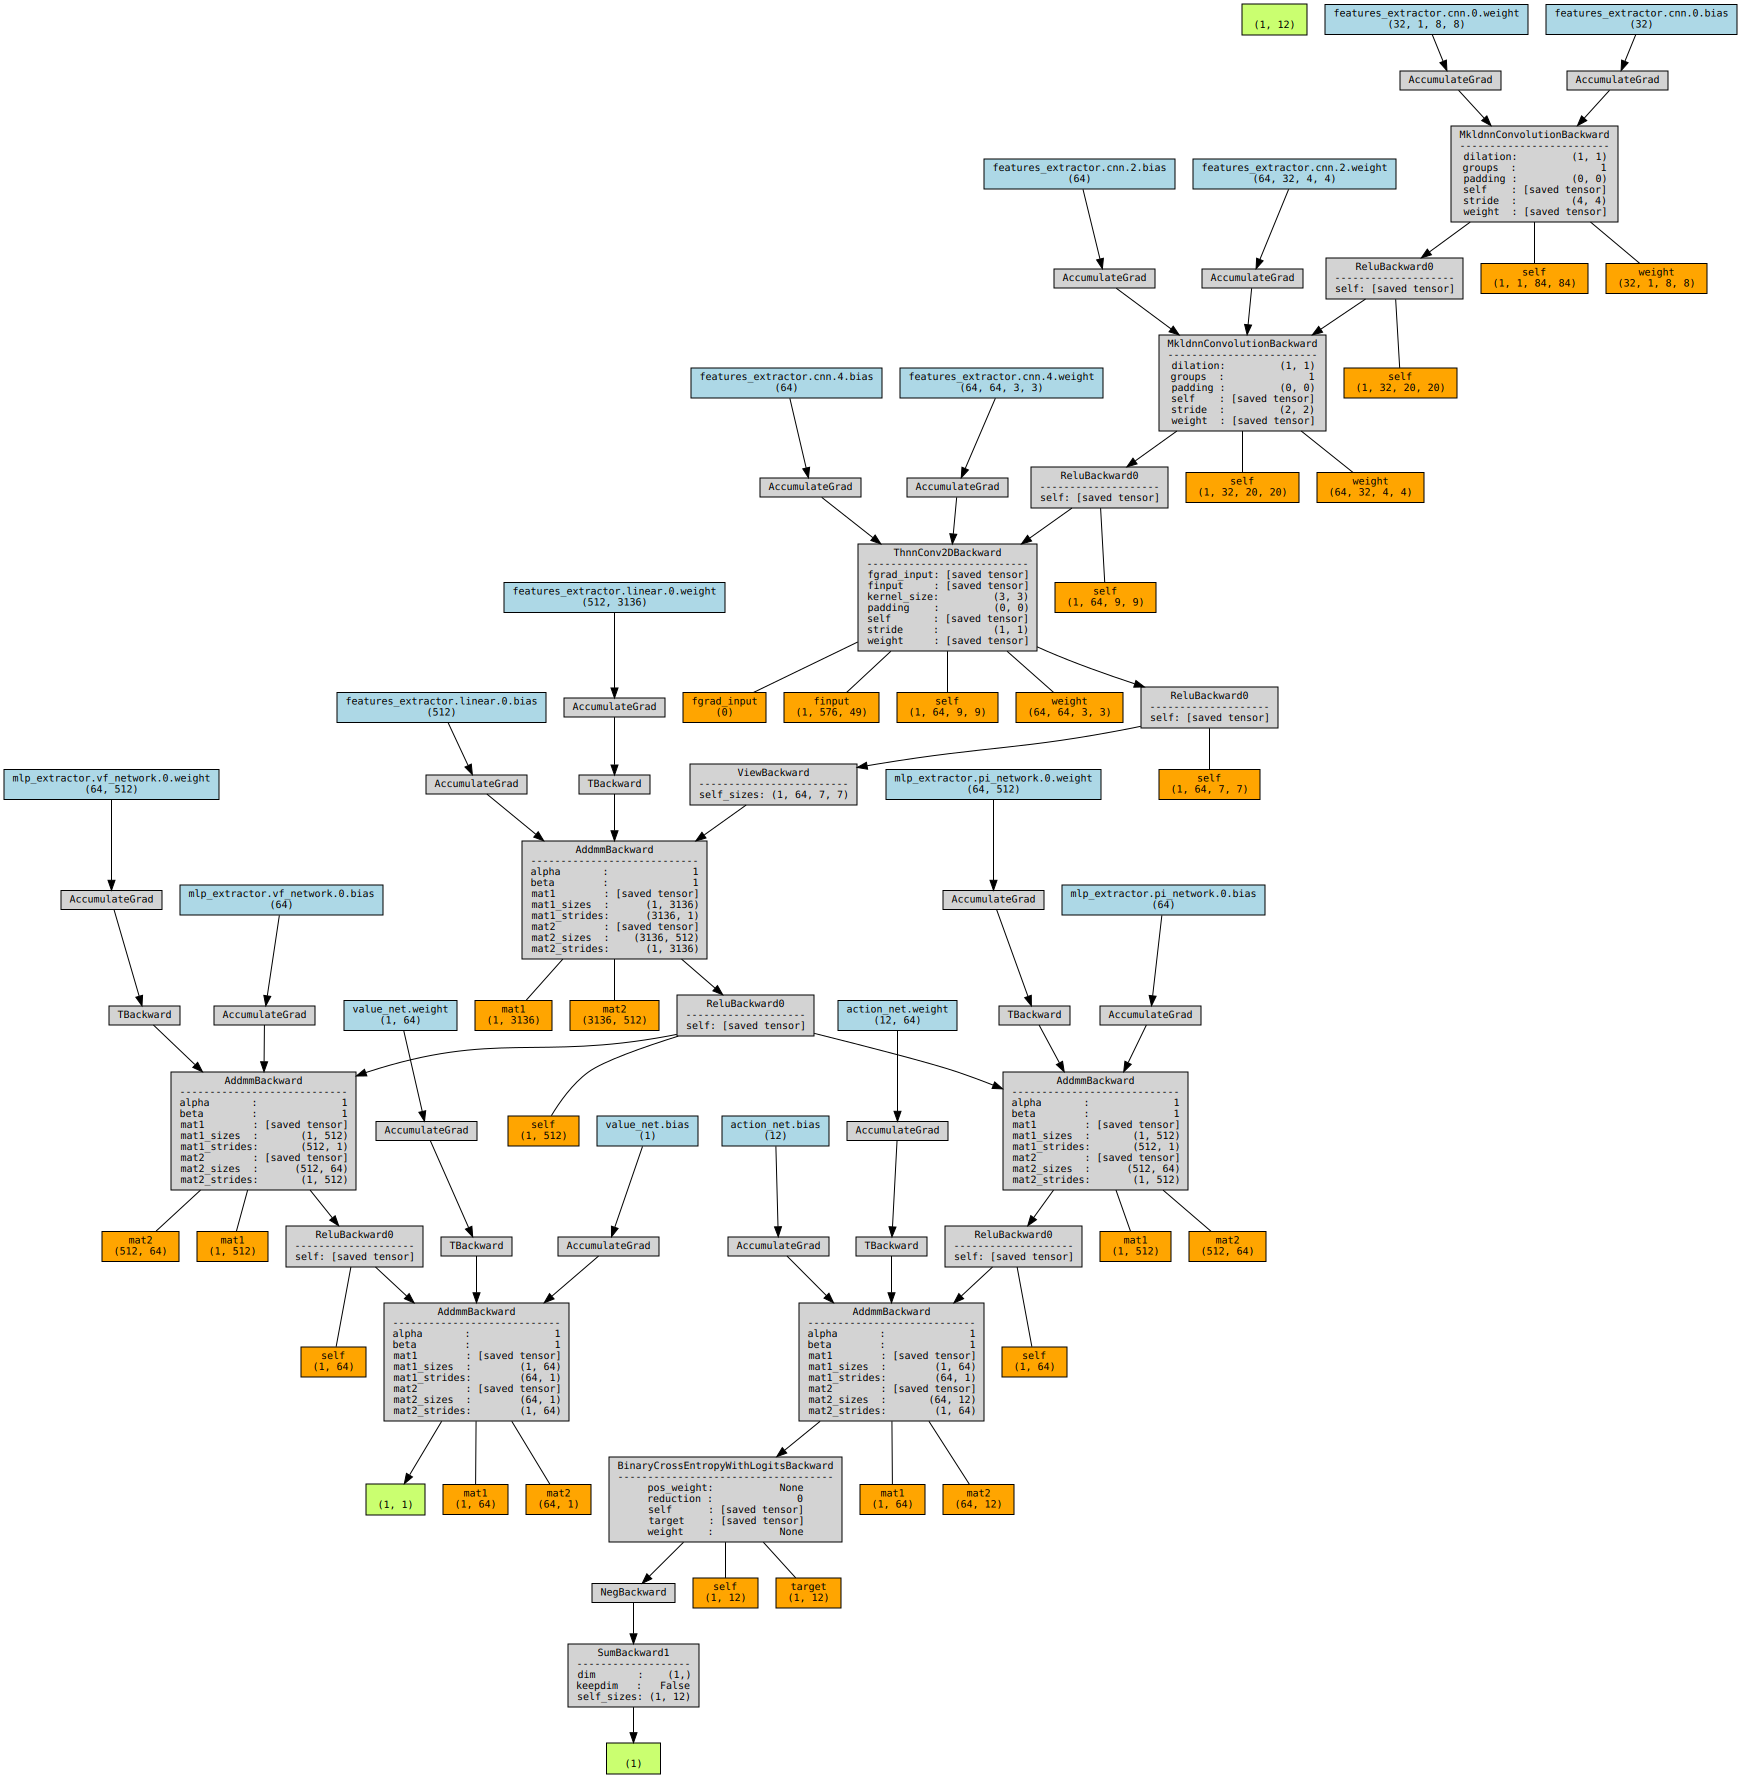

In [9]:
import torch
x = torch.randn(1,1,84,84)
params=dict(model.policy.named_parameters())
make_dot(model.policy(x), params, show_attrs=True, show_saved=True)

In [10]:
summary(model.policy, (1, 84, 84))

Layer (type:depth-idx)                   Output Shape              Param #
├─CNNExtractor: 1-1                      [-1, 512]                 --
|    └─Sequential: 2-1                   [-1, 3136]                --
|    |    └─Conv2d: 3-1                  [-1, 32, 20, 20]          2,080
|    |    └─ReLU: 3-2                    [-1, 32, 20, 20]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 9, 9]            32,832
|    |    └─ReLU: 3-4                    [-1, 64, 9, 9]            --
|    |    └─Conv2d: 3-5                  [-1, 64, 7, 7]            36,928
|    |    └─ReLU: 3-6                    [-1, 64, 7, 7]            --
|    |    └─Flatten: 3-7                 [-1, 3136]                --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-8                  [-1, 512]                 1,606,144
|    |    └─ReLU: 3-9                    [-1, 512]                 --
├─ActorCriticLayer: 1-2                  [-1, 64]                  

Layer (type:depth-idx)                   Output Shape              Param #
├─CNNExtractor: 1-1                      [-1, 512]                 --
|    └─Sequential: 2-1                   [-1, 3136]                --
|    |    └─Conv2d: 3-1                  [-1, 32, 20, 20]          2,080
|    |    └─ReLU: 3-2                    [-1, 32, 20, 20]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 9, 9]            32,832
|    |    └─ReLU: 3-4                    [-1, 64, 9, 9]            --
|    |    └─Conv2d: 3-5                  [-1, 64, 7, 7]            36,928
|    |    └─ReLU: 3-6                    [-1, 64, 7, 7]            --
|    |    └─Flatten: 3-7                 [-1, 3136]                --
|    └─Sequential: 2-2                   [-1, 512]                 --
|    |    └─Linear: 3-8                  [-1, 512]                 1,606,144
|    |    └─ReLU: 3-9                    [-1, 512]                 --
├─ActorCriticLayer: 1-2                  [-1, 64]                  

In [11]:
summary(model.policy, (1, 84, 84),  
    branching=False,
    verbose=2,
    col_width=16,
    col_names=["kernel_size", "input_size", "output_size", "num_params", "mult_adds"])

Layer (type:depth-idx)                   Kernel Shape     Input Shape      Output Shape     Param #          Mult-Adds
CNNExtractor: 1-1                        --               [-1, 1, 84, 84]  [-1, 512]        --               --
  cnn.0.weight                           [32, 1, 8, 8]
  cnn.2.weight                           [64, 32, 4, 4]
  cnn.4.weight                           [64, 64, 3, 3]
  linear.0.weight                        [512, 3136]
Sequential: 2-1                          --               [-1, 1, 84, 84]  [-1, 3136]       --               --
  0.weight                               [32, 1, 8, 8]
  2.weight                               [64, 32, 4, 4]
  4.weight                               [64, 64, 3, 3]
Conv2d: 3-1                              [1, 32, 8, 8]    [-1, 1, 84, 84]  [-1, 32, 20, 20] 2,080            819,200
ReLU: 3-2                                --               [-1, 32, 20, 20] [-1, 32, 20, 20] --               --
Conv2d: 3-3                              

Layer (type:depth-idx)                   Kernel Shape     Input Shape      Output Shape     Param #          Mult-Adds
CNNExtractor: 1-1                        --               [-1, 1, 84, 84]  [-1, 512]        --               --
  cnn.0.weight                           [32, 1, 8, 8]
  cnn.2.weight                           [64, 32, 4, 4]
  cnn.4.weight                           [64, 64, 3, 3]
  linear.0.weight                        [512, 3136]
Sequential: 2-1                          --               [-1, 1, 84, 84]  [-1, 3136]       --               --
  0.weight                               [32, 1, 8, 8]
  2.weight                               [64, 32, 4, 4]
  4.weight                               [64, 64, 3, 3]
Conv2d: 3-1                              [1, 32, 8, 8]    [-1, 1, 84, 84]  [-1, 32, 20, 20] 2,080            819,200
ReLU: 3-2                                --               [-1, 32, 20, 20] [-1, 32, 20, 20] --               --
Conv2d: 3-3                              

In [12]:
type(model.policy.value_net)

torch.nn.modules.linear.Linear